In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

d:\Programy\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'D:\Programy\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [3]:
# !nvidia-smi

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


In [43]:
from typing import Optional, Callable, Tuple, Any
import numpy as np
from PIL import Image
import os


class MagicDataset(torch.utils.data.Dataset):
    def __init__(
        self, 
        img_dir: str,
        labels_file: Optional[str] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None
    ) -> None:

        self.img_dir = img_dir
        self.labels_file = labels_file
        self.data = pd.read_csv(labels_file)
        self.img_names = self.data.loc[:, "filename"]
        self.img_labels = self.data.loc[:, "category_id"]

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self) -> int:
        return len(self.img_names)

    def __getitem__(self, index: int):
        img_path = os.path.join(self.img_dir, self.img_names[index])
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels[index]

        if self.transform:
            image = self.transform(image)
            
        if self.target_transform:
            label = self.target_transform(label)

        return image, label
    

In [37]:
IMG_DIR = 'data/reference_images_part1_bboxes/images'
LABELS_FILE = 'data/reference_images_part1_bboxes/bboxes_data.csv'
BATCH_SIZE = 64

In [44]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [45]:
train_data = MagicDataset(img_dir=IMG_DIR, labels_file=LABELS_FILE, transform=train_transforms)

In [46]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

In [48]:
def imshow(img, title=None):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean # unnormalize 
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

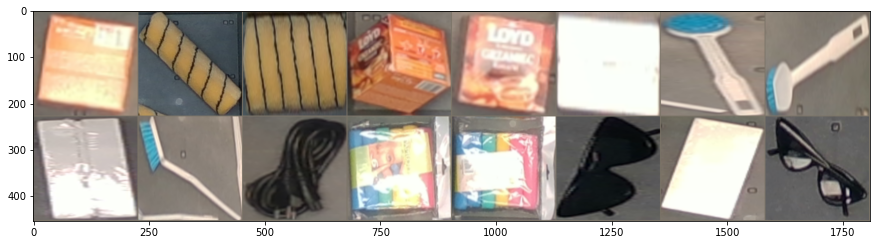

In [54]:
images, labels = next(iter(train_loader))

plt.rcParams['figure.figsize'] = 15, 10
imshow(torchvision.utils.make_grid(images[:16]))

# Model 

In [89]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model = torch.nn.Sequential(*(list(model.children())[:-1]), torch.nn.Flatten())

model = model.to(device)

In [90]:
model.eval()

with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs)
        break

In [79]:
torch.abs(outputs[4] - outputs[5]).sum()

tensor(241.5154)